In [2]:
# import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Galvanic Skin Response GSR
gsr_features = pd.read_excel('gsr_features.xlsx')
gsr_features.rename(columns={'Unnamed: 0':'participant'}, inplace=True) # add name to first column
# Pupillary Dilation PD
pupil_features = pd.read_excel('pupil_features.xlsx')
pupil_features.rename(columns={'Unnamed: 0':'participant'}, inplace=True)
# Skin Temperature ST
skintemp_features = pd.read_excel('skintemp_features.xlsx')
skintemp_features.rename(columns={'Unnamed: 0':'participant'}, inplace=True)
# X_all uses features from all signals
X_all = pd.concat([gsr_features, pupil_features.iloc[:, 2::], skintemp_features.iloc[:, 2::]], axis=1)

In [4]:
#pd.reset_option("max_columns")
#pd.set_option('max_columns', None)
#pd.reset_option("min_rows")

In [5]:
dataset = X_all
df = dataset.copy()
df2 = dataset.copy()
# Apply min-max scaling on the unnormalised columns
df = df.iloc[:, 2::]
df = df.loc[:,df.mean()>1]
df=(df-df.min())/(df.max()-df.min())
for col in df.columns:
    df2[col] = df[col]
dataset = df2

In [7]:
dataset = df2
dataset

,participant,depr_label,min_normalised_gsr,max_normalised_gsr,mean_normalised_gsr,std_normalised_gsr,var_normalised_gsr,rms_normalised_gsr,min_filtered_gsr,max_filtered_gsr,...,second_diff_normalised_skintemp_abs_mean,first_diff_filtered_skintemp_abs_mean,second_diff_filtered_skintemp_abs_mean,num_normalised_skintemp_peaks,num_filtered_skintemp_peaks,vlp_skintemp_peak_occurrences,lp_skintemp_peak_occurrences,mean_vlp_skintemp_peak_amplitudes,mean_lp_skintemp_peak_amplitudes,ratio_skintemp_peak_occurrence_vlp_lp
0,p02,2,0.716610,0.970557,0.821910,0.072007,0.005185,0.825042,0.980664,1.405398,...,0.004944,0.071831,0.137465,0.416667,0.4,0.333333,0.636364,0.166276,0.002174,0.200000
1,p02,2,0.553351,0.718968,0.630662,0.047855,0.002290,0.632464,0.803887,0.975663,...,0.005144,0.001383,0.002745,0.333333,0.3,0.000000,0.090909,0.329021,-0.064926,0.250000
2,p02,2,0.530042,0.873545,0.607463,0.073371,0.005383,0.611853,0.775245,1.096903,...,0.005573,0.001172,0.002322,0.666667,0.4,0.333333,0.363636,0.234310,-0.013983,0.285714
3,p02,2,0.407362,0.515320,0.458619,0.030267,0.000916,0.459610,0.652096,0.765979,...,0.004863,0.001020,0.002030,0.666667,0.2,0.000000,0.000000,0.420307,0.010984,0.333333
4,p02,0,0.307992,0.401229,0.353097,0.027189,0.000739,0.354137,0.543863,0.641232,...,0.005788,0.001512,0.003005,0.500000,0.4,0.333333,0.454545,0.285511,0.008479,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,p14,2,0.478860,0.689492,0.531518,0.050495,0.002550,0.533896,3.405516,3.776510,...,0.006883,0.001046,0.002082,0.416667,0.3,0.666667,0.545455,0.005077,-0.000736,0.333333
188,p14,3,0.508756,0.824976,0.599765,0.072180,0.005210,0.604066,3.469690,4.094220,...,0.007320,0.001801,0.003571,0.500000,0.4,0.666667,0.363636,0.003171,-0.001051,0.428571
189,p14,3,0.574068,0.942852,0.709688,0.087339,0.007628,0.715010,3.590318,4.409810,...,0.006555,0.001031,0.002036,0.500000,0.4,0.333333,0.636364,0.006459,-0.000129,0.200000
190,p14,3,0.691630,0.969521,0.762679,0.058613,0.003435,0.764914,3.831880,4.473302,...,0.006118,0.001128,0.002233,0.500000,0.4,0.333333,0.454545,0.010085,-0.000088,0.250000


In [8]:
# define a customised neural network structure
class TwoLayerNet(nn.Module):

    def __init__(self, n_input, n_hidden, n_output):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_output)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
# leave-one-participant-out method for cross-validation
participants = np.unique(dataset['participant'].values)
best_acc = 0
best_epoch = 0
for epoch_test in range(20,251,5):
    acc = 0
    for chosen in participants:
        msk = dataset['participant'] == chosen
        test_data = dataset[msk]
        train_data = dataset[~msk]

        num_features = train_data.shape[1] - 2

        # split training data into input and target
        # drop the first column (participant)
        # the second column is target and the rest are features
        train_data = train_data.drop(columns='participant')
        train_input = train_data.iloc[:, 1:,]
        train_target = train_data.iloc[:, :1:]

        # split test data into input and target
        # drop the first column (participant)
        # the second column is target and the restare features
        test_data = test_data.drop(columns='participant')
        test_input = test_data.iloc[:, 1:,]
        test_target = test_data.iloc[:, :1:]

        # # create Tensors to hold inputs and outputs
        X = torch.Tensor(train_input.values).float()
        Y = torch.Tensor(train_target.values).long().squeeze()

        # -- Train Model --
        # define the number of inputs, classes, training epochs, and learning rate
        input_neurons = X.shape[1]
        hidden_neurons = 100
        output_neurons = np.unique(Y).size
        learning_rate = 0.002
        weight_decay_rate = 0.001

        # define a neural network using the customised structure 
        net = TwoLayerNet(input_neurons, hidden_neurons, output_neurons)

        # define loss function (https://pytorch.org/docs/stable/nn.html#loss-functions)
        loss_func = torch.nn.CrossEntropyLoss()


        # define optimiser (https://pytorch.org/docs/stable/optim.html)
        optimiser = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay = weight_decay_rate)

        # store all losses for visualisation
        all_losses = []

        # train a neural network
        for epoch in range(epoch_test):
            # Perform forward pass: compute predicted y by passing x to the model.
            Y_pred = net(X)

            # Compute loss
            loss = loss_func(Y_pred, Y)
            all_losses.append(loss.item())

            # print progress
            #if epoch % 50 == 0:
            if epoch+1 == epoch_test:
                # convert three-column predicted Y values to one column for comparison
                _, predicted = torch.max(Y_pred, 1)

                # calculate and print accuracy
                total = predicted.size(0)
                correct = predicted.data.numpy() == Y.data.numpy()
                print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
                      % (epoch + 1, epoch_test, loss.item(), 100 * sum(correct)/total))

            # Clear the gradients before running the backward pass.
            net.zero_grad()

            # Perform backward pass
            loss.backward()

            # Calling the step function on an Optimiser makes an update to its
            # parameters
            optimiser.step()

        # -- Test Model --
        # create Tensors to hold inputs and outputs
        X_test = torch.Tensor(test_input.values).float()
        Y_test = torch.Tensor(test_target.values).long().squeeze()


        # Here, Y_pred_test contains three columns, where the index of the
        # max column indicates the class of the instance
        net.eval()
        Y_pred_test = net(X_test)

        # get prediction
        # convert three-column predicted Y values to one column for comparison
        _, predicted_test = torch.max(Y_pred_test, 1)

        # calculate accuracy
        total_test = predicted_test.size(0)
        correct_test = sum(predicted_test.data.numpy() == Y_test.data.numpy())

        #print('Testing Accuracy: %.2f %%' % (100 * correct_test / total_test))
        acc += 100.0 * correct_test / total_test
            
    if acc >= best_acc:
        best_acc = acc
        best_epoch = epoch_test
        no_improve = 0
        torch.save({
            'epoch': best_epoch,
            'model_state_dict': net.state_dict(),
            'optimiser_state_dict': optimiser.state_dict(),
            'loss': loss,
            }, "best_all.pt")
    elif acc <= best_acc:
        no_improve += 1
        if no_improve == 10:
            break
    print(acc/len(participants))

In [468]:
# All
# 32.291666666666664
# epoch 105
# hidden_neurons = 100
# learning_rate = 0.002
# weight_decay_rate = 0.001

# GSR
# 32.8125
# 205
#        hidden_neurons = 100
#        learning_rate = 0.001
#        weight_decay_rate = 0.001



# Pupil
# 32.8125
# 125
#        hidden_neurons = 100
#        learning_rate = 0.001
#        weight_decay_rate = 0.001

# Skin Temp
#35.9375
#45
#        hidden_neurons = 100
#        learning_rate = 0.001
#        weight_decay_rate = 0.001

print(best_acc/12)
print(best_epoch)

32.291666666666664
105


In [9]:
# use the whole dataset as training set 
train_data = dataset
test_data = dataset

num_features = train_data.shape[1] - 2

# split training data into input and target
# drop the first column (participant)
# the second column is target and the rest are features
train_data = train_data.drop(columns='participant')
train_input = train_data.iloc[:, 1:,]
train_target = train_data.iloc[:, :1:]

# split test data into input and target
# drop the first column (participant)
# the second column is target and the restare features
test_data = test_data.drop(columns='participant')
test_input = test_data.iloc[:, 1:,]
test_target = test_data.iloc[:, :1:]

# # create Tensors to hold inputs and outputs
X = torch.Tensor(train_input.values).float()
Y = torch.Tensor(train_target.values).long().squeeze()

# -- Train Model --
# define the number of inputs, classes, training epochs, and learning rate
input_neurons = X.shape[1]
hidden_neurons = 100
output_neurons = np.unique(Y).size
learning_rate = 0.002
weight_decay_rate = 0.001
num_epoch = 105

# define a neural network using the customised structure 
net = TwoLayerNet(input_neurons, hidden_neurons, output_neurons)

# define loss function (https://pytorch.org/docs/stable/nn.html#loss-functions)
loss_func = torch.nn.CrossEntropyLoss()


# define optimiser (https://pytorch.org/docs/stable/optim.html)
optimiser = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay = weight_decay_rate)

In [10]:
# store all losses for visualisation
all_losses = []

# train a neural network
for epoch in range(num_epoch):
    # Perform forward pass: compute predicted y by passing x to the model.
    Y_pred = net(X)

    # Compute loss
    loss = loss_func(Y_pred, Y)
    all_losses.append(loss.item())

    # print progress
    if epoch % 50 == 0:
        # convert three-column predicted Y values to one column for comparison
        _, predicted = torch.max(Y_pred, 1)

        # calculate and print accuracy
        total = predicted.size(0)
        correct = predicted.data.numpy() == Y.data.numpy()

        print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
              % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))

    # Clear the gradients before running the backward pass.
    net.zero_grad()

    # Perform backward pass
    loss.backward()

    # Calling the step function on an Optimiser makes an update to its
    # parameters
    optimiser.step()

Epoch [1/105] Loss: 1.3919  Accuracy: 20.31 %
Epoch [51/105] Loss: 1.1477  Accuracy: 48.44 %
Epoch [101/105] Loss: 1.0142  Accuracy: 58.85 %


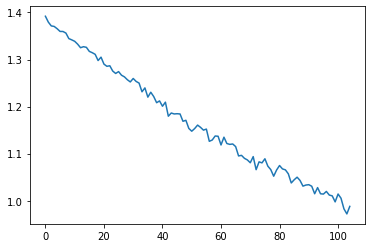

In [11]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [17]:
from sklearn import metrics
model=net
# -- Test Model --
# create Tensors to hold inputs and outputs
X_test = torch.Tensor(test_input.values).float()
Y_test = torch.Tensor(test_target.values).long().squeeze()


# Here, Y_pred_test contains three columns, where the index of the
# max column indicates the class of the instance
net.eval()
Y_pred_test = model(X_test)

# get prediction
# convert three-column predicted Y values to one column for comparison
_, predicted_test = torch.max(Y_pred_test, 1)

print('Confusion matrix for testing:')

# Print the confusion matrix
print(metrics.confusion_matrix(Y_test, predicted_test))

# Print the precision and recall, among other metrics
print(metrics.classification_report(Y_test, predicted_test, digits=3))

Confusion matrix for testing:
[[33  3  7  5]
 [ 7 28  7  6]
 [ 7  7 28  6]
 [ 3  8  8 29]]
              precision    recall  f1-score   support

           0      0.660     0.688     0.673        48
           1      0.609     0.583     0.596        48
           2      0.560     0.583     0.571        48
           3      0.630     0.604     0.617        48

    accuracy                          0.615       192
   macro avg      0.615     0.615     0.614       192
weighted avg      0.615     0.615     0.614       192



In [18]:
# Implement magniture measure (Gedeon 1996)
w_ih = model.fc1.weight.detach().numpy()
w_ho = model.fc2.weight.detach().numpy()

# Contribution of input neurons to hidden neurons P_ij
denominator = np.zeros(w_ih.shape[0])
P_ij = np.zeros(w_ih.shape)
for i in range(w_ih.shape[0]):
    denominator[i] = np.abs(w_ih[i]).sum()
for i in range(w_ih.shape[0]):
    for j in range(w_ih.shape[1]):
        P_ij[i][j] = np.abs(w_ih[i][j]) / denominator[i]
        
# Contribution of hidden neurons to output neurons P_jk
denominator = np.zeros(w_ho.shape[0])
P_jk = np.zeros(w_ho.shape)
for i in range(w_ho.shape[0]):
    denominator[i] = np.abs(w_ho[i]).sum()
for j in range(w_ho.shape[0]):
    for k in range(w_ho.shape[1]):
        P_jk[j][k] = np.abs(w_ho[j][k]) / denominator[j]

# Contribution of input neurons to output neurons Q_ik
Q_ik = np.zeros((w_ih.shape[1], w_ho.shape[0]))
for i in range(w_ih.shape[1]):
    for k in range(w_ho.shape[0]):
        for j in range(w_ih.shape[0]):
            Q_ik[i][k] += P_ij[j][i] * P_jk[k][j]

# Average the contribution of inputs to the 4 outputs and sort
indices = np.argsort(Q_ik.mean(axis=1)) # sorts in ascending order
indices = indices[::-1] # reverse order
indices

array([80, 21,  1,  3, 18,  2,  5, 82, 23, 20, 48,  0, 64, 58, 62, 67, 17,
       44, 79, 83, 81, 61, 34, 63, 72, 36, 16, 78, 35, 31, 57, 71, 84, 59,
       22, 73, 69, 65, 70, 33, 68, 19, 32, 45, 49, 38,  8,  7, 41, 37, 11,
       39, 24,  6, 50, 46,  4, 26, 52, 25, 51, 54,  9, 60, 28, 75, 47, 77,
       12, 13, 40, 74, 27, 76, 43, 15, 53, 10, 66, 30, 56, 42, 14, 29, 55],
      dtype=int64)

In [127]:
reduced_dataset = dataset.drop(dataset.columns[indices[0:1]+2],axis=1)
reduced_dataset.shape

(192, 86)

In [152]:
np.sort(Q_ik.mean(axis=1))

array([0.000882  , 0.00091618, 0.00119703, 0.00143524, 0.00148655,
       0.00167246, 0.00168316, 0.00200719, 0.00206511, 0.00235712,
       0.00260868, 0.00412627, 0.00415134, 0.00463504, 0.00488084,
       0.00560188, 0.00590604, 0.00671563, 0.00752657, 0.00852674,
       0.00863305, 0.00904913, 0.00907952, 0.0091086 , 0.00914183,
       0.00918801, 0.0092986 , 0.00985623, 0.01004246, 0.01024394,
       0.01037789, 0.01062007, 0.01101012, 0.01147492, 0.01149516,
       0.01150054, 0.01165786, 0.01176584, 0.01200296, 0.01212736,
       0.01240817, 0.01244799, 0.01246869, 0.01265293, 0.01280557,
       0.01286068, 0.01311283, 0.01311354, 0.01356399, 0.01369795,
       0.01377556, 0.01396119, 0.01413979, 0.014143  , 0.01460754,
       0.01478413, 0.01487308, 0.01492236, 0.01516813, 0.0152959 ,
       0.01548404, 0.01552629, 0.01557279, 0.01601912, 0.01602615,
       0.01661305, 0.01663975, 0.01684631, 0.01695522, 0.01722234,
       0.01747641, 0.01752861, 0.01753505, 0.01757474, 0.01760

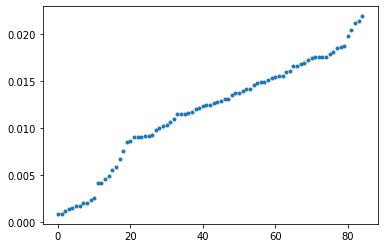

In [135]:
plt.plot(np.sort(Q_ik.mean(axis=1)),'.')

In [140]:
np.array([0+2, 1+2])

array([2, 3])

In [150]:
# store all losses for visualisation
all_acc = []
for i in range(0,5):
    for j in range(0,1):
        cols = np.array([i+2])
        reduced_dataset = dataset.drop(dataset.columns[cols],axis=1)
        print("i = {}".format(i))
        # leave-one-participant-out method for cross-validation
        participants = np.unique(reduced_dataset['participant'].values)
        best_acc = 0
        best_epoch = 0
        for epoch_test in range(10,201,5):
            acc = 0
            for chosen in participants:
                msk = reduced_dataset['participant'] == chosen
                test_data = reduced_dataset[msk]
                train_data = reduced_dataset[~msk]

                num_features = train_data.shape[1] - 2

                # split training data into input and target
                # drop the first column (participant)
                # the second column is target and the rest are features
                train_data = train_data.drop(columns='participant')
                train_input = train_data.iloc[:, 1:,]
                train_target = train_data.iloc[:, :1:]

                # split test data into input and target
                # drop the first column (participant)
                # the second column is target and the restare features
                test_data = test_data.drop(columns='participant')
                test_input = test_data.iloc[:, 1:,]
                test_target = test_data.iloc[:, :1:]

                # # create Tensors to hold inputs and outputs
                X = torch.Tensor(train_input.values).float()
                Y = torch.Tensor(train_target.values).long().squeeze()

                # -- Train Model --
                # define the number of inputs, classes, training epochs, and learning rate
                input_neurons = X.shape[1]
                hidden_neurons = 100
                output_neurons = np.unique(Y).size
                learning_rate = 0.002
                weight_decay_rate = 0.001

                # define a neural network using the customised structure 
                net = TwoLayerNet(input_neurons, hidden_neurons, output_neurons)

                # define loss function (https://pytorch.org/docs/stable/nn.html#loss-functions)
                loss_func = torch.nn.CrossEntropyLoss()


                # define optimiser (https://pytorch.org/docs/stable/optim.html)
                optimiser = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay = weight_decay_rate)

                # store all losses for visualisation
                all_losses = []

                # train a neural network
                for epoch in range(epoch_test):
                    # Perform forward pass: compute predicted y by passing x to the model.
                    Y_pred = net(X)

                    # Compute loss
                    loss = loss_func(Y_pred, Y)
                    all_losses.append(loss.item())

                    # print progress
                    #if epoch % 50 == 0:
                    if epoch+1 == epoch_test:
                        # convert three-column predicted Y values to one column for comparison
                        _, predicted = torch.max(Y_pred, 1)

                        # calculate and print accuracy
                        total = predicted.size(0)
                        correct = predicted.data.numpy() == Y.data.numpy()
                        #print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%' % (epoch + 1, epoch_test, loss.item(), 100 * sum(correct)/total))

                    # Clear the gradients before running the backward pass.
                    net.zero_grad()

                    # Perform backward pass
                    loss.backward()

                    # Calling the step function on an Optimiser makes an update to its
                    # parameters
                    optimiser.step()

                # -- Test Model --
                # create Tensors to hold inputs and outputs
                X_test = torch.Tensor(test_input.values).float()
                Y_test = torch.Tensor(test_target.values).long().squeeze()


                # Here, Y_pred_test contains three columns, where the index of the
                # max column indicates the class of the instance
                net.eval()
                Y_pred_test = net(X_test)

                # get prediction
                # convert three-column predicted Y values to one column for comparison
                _, predicted_test = torch.max(Y_pred_test, 1)

                # calculate accuracy
                total_test = predicted_test.size(0)
                correct_test = sum(predicted_test.data.numpy() == Y_test.data.numpy())

                #print('Testing Accuracy: %.2f %%' % (100 * correct_test / total_test))
                acc += 100.0 * correct_test / total_test

            if acc >= best_acc:
                best_acc = acc
                best_epoch = epoch_test
                no_improve = 0
        #         torch.save({
        #             'epoch': best_epoch,
        #             'model_state_dict': net.state_dict(),
        #             'optimiser_state_dict': optimiser.state_dict(),
        #             'loss': loss,
        #             }, "best_all.pt")
            elif acc <= best_acc:
                no_improve += 1
                if no_improve == 7:
                    all_acc.append(best_acc)
                    break
            #print("epoch num = {}".format(epoch_test))
            #print("avg accuracy = {}".format(acc/len(participants)))

i = 0
i = 1
i = 2
i = 3
i = 4


In [151]:
np.divide(all_acc,12)

array([31.77083333, 31.77083333, 32.29166667, 32.29166667, 32.29166667])

In [148]:
np.divide(all_acc,12)

array([31.77083333, 32.8125    , 31.25      , 32.29166667, 30.20833333,
       32.29166667, 30.72916667, 32.29166667, 30.72916667, 33.85416667])

In [121]:
print(best_acc/12)
print(best_epoch)

29.166666666666668
20


In [108]:
# use the whole dataset as training set 
train_data = reduced_dataset
test_data = reduced_dataset

num_features = train_data.shape[1] - 2

# split training data into input and target
# drop the first column (participant)
# the second column is target and the rest are features
train_data = train_data.drop(columns='participant')
train_input = train_data.iloc[:, 1:,]
train_target = train_data.iloc[:, :1:]

# split test data into input and target
# drop the first column (participant)
# the second column is target and the restare features
test_data = test_data.drop(columns='participant')
test_input = test_data.iloc[:, 1:,]
test_target = test_data.iloc[:, :1:]

# # create Tensors to hold inputs and outputs
X = torch.Tensor(train_input.values).float()
Y = torch.Tensor(train_target.values).long().squeeze()

# -- Train Model --
# define the number of inputs, classes, training epochs, and learning rate
input_neurons = X.shape[1]
hidden_neurons = 100
output_neurons = np.unique(Y).size
learning_rate = 0.002
weight_decay_rate = 0.001
num_epoch = 10

# define a neural network using the customised structure 
net = TwoLayerNet(input_neurons, hidden_neurons, output_neurons)

# define loss function (https://pytorch.org/docs/stable/nn.html#loss-functions)
loss_func = torch.nn.CrossEntropyLoss()


# define optimiser (https://pytorch.org/docs/stable/optim.html)
optimiser = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay = weight_decay_rate)

In [109]:
# store all losses for visualisation
all_losses = []

# train a neural network
for epoch in range(num_epoch):
    # Perform forward pass: compute predicted y by passing x to the model.
    Y_pred = net(X)

    # Compute loss
    loss = loss_func(Y_pred, Y)
    all_losses.append(loss.item())

    # print progress
    if epoch % 50 == 0:
        # convert three-column predicted Y values to one column for comparison
        _, predicted = torch.max(Y_pred, 1)

        # calculate and print accuracy
        total = predicted.size(0)
        correct = predicted.data.numpy() == Y.data.numpy()

        print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
              % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))

    # Clear the gradients before running the backward pass.
    net.zero_grad()

    # Perform backward pass
    loss.backward()

    # Calling the step function on an Optimiser makes an update to its
    # parameters
    optimiser.step()

Epoch [1/10] Loss: 1.3879  Accuracy: 25.52 %


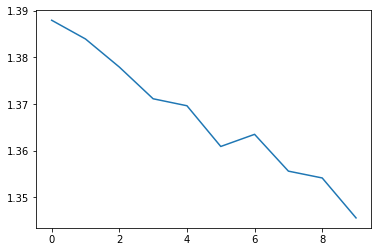

In [110]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [111]:
from sklearn import metrics
model=net
# -- Test Model --
# create Tensors to hold inputs and outputs
X_test = torch.Tensor(test_input.values).float()
Y_test = torch.Tensor(test_target.values).long().squeeze()


# Here, Y_pred_test contains three columns, where the index of the
# max column indicates the class of the instance
net.eval()
Y_pred_test = model(X_test)

# get prediction
# convert three-column predicted Y values to one column for comparison
_, predicted_test = torch.max(Y_pred_test, 1)

print('Confusion matrix for testing:')

# Print the confusion matrix
print(metrics.confusion_matrix(Y_test, predicted_test))

# Print the precision and recall, among other metrics
print(metrics.classification_report(Y_test, predicted_test, digits=3))

Confusion matrix for testing:
[[18 14  3 13]
 [ 5 26  1 16]
 [10 10  7 21]
 [ 3 16  1 28]]
              precision    recall  f1-score   support

           0      0.500     0.375     0.429        48
           1      0.394     0.542     0.456        48
           2      0.583     0.146     0.233        48
           3      0.359     0.583     0.444        48

    accuracy                          0.411       192
   macro avg      0.459     0.411     0.391       192
weighted avg      0.459     0.411     0.391       192



In [13]:
model = net
optimizer = optimiser

PATH = "best_all.pt"

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimiser_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']